In [2]:
from __future__ import print_function

%matplotlib inline
%load_ext autoreload
%autoreload 2

import glob
import os
import numpy as np
import importlib_resources
import pathlib
import shutil
import h5py

# Load nuPyProp data & models modules
from nupyprop import data
from nupyprop import models

# Load astropy modules
from astropy.table import Table
from astropy.io import ascii

# Plotting modules
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt
from itertools import cycle
import seaborn as sns
import itertools



sns.set_theme()
sns.set_context("paper")
sns.set_style("white", {"font.family": "STIXGeneral"})

# Plotting defaults
mpl.rcParams['xtick.labelsize'] = 26
mpl.rcParams['ytick.labelsize'] = 26
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 1.5
mpl.rcParams['xtick.major.pad'] = 8
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 1.5
mpl.rcParams['ytick.major.pad'] = 8
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['legend.fontsize'] = 23
plt.rcParams['legend.title_fontsize'] = 23
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['axes.titlesize'] = 30
mpl.rcParams['figure.titlesize'] = 30
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.linewidth'] = 2

# See output files in data directory

In [ ]:
for file in glob.glob('data/*.h5'):
    print(file)
    
os.chdir('data')

# See output file attributes (ie. input parameters with which the simulation was run)

In [ ]:
hdf5_file = 'output_nu_tau_4km_ct18nlo_allm_stochastic_1e8.h5' # select your output file
with h5py.File(hdf5_file, 'r') as hf:
    for attr in hf.attrs:
        print(str(attr) + " = " + str(hf.attrs[attr])) # print the file attributes

# Set desired parameters for output file

In [4]:
nu_type = 'neutrino' # nu for neutrino & anu for anti-neutrino
ch_lepton = 'tau' # type of charged lepton
cross_section_model = 'ct18nlo' # neutrino cross-section model
pn_model = 'allm' # photonuclear energy loss model
pn_models = 'bdhm'
idepth = 4 # depth of water layer in km
stats = 1e7 # no. of ingoing neutrinos ie., statistics (also mentioned in the file name)
prop_type = 'stochastic' # type of energy loss; can be stochastic or continuous


## Sec I: Plot the exit probability vs. Earth emergence angles

In [ ]:
energies = np.logspace(6,12,25) # default energies in nuPyProp
angles1 = np.arange(0.1,1,0.1).astype('float64') # default angles in nuPyProp
angles2 = np.arange(1,43).astype('float64') 
angles = np.concatenate((angles1,angles2), axis=None)

fig, axs = plt.subplots(1, figsize=(10/1.1, 8/1.1))

energy_grp = [] # so that 7, 7.25, etc. are grouped into the same legend

lines = ["--","-.",":",(0,(3,1,1,1))]
linecycler = cycle(lines)

# colors = ['r','g','b','k','m']
# color_map = cycle(colors)
color_map = cycle(sns.color_palette("colorblind"))

for i,energy in enumerate(energies):

    pexit_no_regen = data.get_pexit(nu_type, ch_lepton, energy, idepth, cross_section_model, pn_model, prop_type, stats)[0] # without regen
    pexit_regen = data.get_pexit(nu_type, ch_lepton, energy, idepth, cross_section_model, pn_model, prop_type, stats)[1] # with regen

    energy_log = float(np.log10(energy))

    if int(np.log10(energy)) not in energy_grp:
        color = next(color_map)
        energy_grp.append(int(np.log10(energy)))

        if energy_log%2 == 0 or (energy_log+1)%2 == 0:
            axs.loglog(angles, pexit_regen, c = color, label = '%.0d' % energy_log)
        else:
            axs.loglog(angles, pexit_regen, c = color, label = '%.2f' % energy_log)
            
    else:
        axs.loglog(angles, pexit_regen, ls = next(linecycler), color = color)


axs.legend(loc='best', ncol=2, title = r'log$_{10}(E_{\nu}/GeV)$', frameon=False, framealpha=0.5, fontsize=23)

ticks = (1,2,3,4,5,10,15,20,30,40)
axs.set_xticks(ticks)
axs.set_xticklabels([i for i in ticks])
axs.grid(which='major', axis='both', linestyle='--')
axs.grid(which='minor', linestyle=':', linewidth='0.2', color='black')
axs.xaxis.set_ticks_position('both')
axs.yaxis.set_ticks_position('both')
axs.tick_params(axis='x', which='both', labelbottom = True, labeltop = False)
axs.tick_params(axis='y', which='both', left = True, labelleft = True, labelright= True)
for axis in [axs.xaxis]:
    axis.set_major_formatter(ScalarFormatter())
    
axs.set_xlabel(r"$\beta_{tr}$ [degrees]")
if ch_lepton=='tau':axs.set_ylabel(r'$P^{(\tau)}_{exit}$')
if ch_lepton=='muon':axs.set_ylabel(r'$P^{(\mu)}_{exit}$')
#axs.set_title(r"$P_{exit}$ Vs. Earth Emergence Angles for %ss" % str.capitalize(ch_lepton), fontsize=27)
axs.set_ylim(1e-6,1e-1)
axs.set_xlim(1,42)
plt.tight_layout()
plt.savefig('pexit-rainbow.pdf', bbox_inches='tight', dpi=400)
plt.show()

## Sec II: Plot outgoing charged lepton energy distribution

In [ ]:
energies = [1e8] # [1e6,1e7,1e8,1e9,1e10,1e11,1e12]
angles = np.array([1,10,20,35]).astype('float64')
# e_out_type = 'cdf' # for plot type CDF
e_out_type = 'no_cdf' # for plot type histogram

E_nu = data.E_nu # neutrino energy bins
color_map = cycle(sns.color_palette("colorblind")[0:len(angles)])
lss = [':', '-.', '--', '-']

for energy in energies:
    fig, axs = plt.subplots(1, figsize=(10/1.1,8/1.1))
    energy_log = float(np.log10(energy))

    for angle in range(len(angles)):
        e_out = data.get_clep_out(nu_type, ch_lepton, energy, angles[angle], idepth, cross_section_model, pn_model, prop_type, stats)
        
        bins = E_nu # binned according to E_nu
        count, bins_count = np.histogram(e_out, bins)
        pdf = count / sum(count)
        dist = count / max(count) # normalized
        cdf = np.cumsum(dist)/np.cumsum(dist)[-1] # normalized
        dist = np.insert(dist,0,0)
        cdf = np.insert(cdf,0,0)
        
        if e_out_type == 'no_cdf':
            axs.step(E_nu, dist, where='pre', ls = lss[angle], color = next(color_map), label = r'$%.f^\circ$' % angles[angle], linewidth=2)
            axs.set_xscale('log')
            if ch_lepton=='muon':axs.set_ylabel(r"Scaled $N_{\mu}$", fontsize = 26)
            if ch_lepton=='tau':axs.set_ylabel(r"Scaled $N_{\tau}$", fontsize = 26)

        else:
            axs.semilogx(E_nu, cdf, ls = '-', color = next(color_map), label = r'$%.f^\circ$' % angles[angle]) # normalized CDF
            axs.set_ylabel("CDF", fontsize = 26)

        if ch_lepton=='tau':
            axs.set_xlabel(r"$E_{\tau}$ [GeV]", fontsize = 26)
            axs.set_xlim(1e5,energy*10)
        if ch_lepton=='muon':
            axs.set_xlabel(r"$E_{\mu}$ [GeV]", fontsize = 26)
            axs.set_xlim(100,energy*10)
        
        if energy_log%2 == 0 or (energy_log+1)%2 == 0:axs.set_title(r"log$_{10}(E_{\nu}$/GeV) = %.2f" % energy_log)
        else:axs.set_title(r"log$_{10}(E_{\nu}/GeV) = %.2f$" % energy_log)
        
        axs.legend(loc='best', ncol=int(np.ceil(len(angles)/8)), title = r'$\beta_{tr}$', frameon=False, framealpha=0.5, fontsize=24)
        #axs.grid(which='major', axis='both', linestyle='--')
        #axs.grid(which='minor', linestyle=':', linewidth='0.2', color='black')
        axs.xaxis.set_ticks_position('both')
        axs.yaxis.set_ticks_position('both')
        axs.tick_params(axis='x', which='both', labelbottom = True, labeltop = False)
        axs.tick_params(axis='y', which='both', left = True, labelleft = True, labelright= False)
        axs.set_ylim(0,1.2)
    plt.savefig('energy-dist-8.pdf', bbox_inches='tight', dpi=400)
    plt.tight_layout()

## Sec III: Plot outgoing charged lepton binned energy CDF (binned according to nuSpaceSim standards)

In [ ]:
energies = [1e6,1e7,1e8,1e9,1e10,1e11,1e12]
angles = np.array([1,10,20,30,40]).astype('float64')

color_map = cycle(sns.color_palette("colorblind")[0:len(angles)])

energy_multiplier = {6:1e-2,7:1e-2,8:1e-3,9:1e-4,10:1e-5,11:1e-5,12:1e-5}

z = data.get_cdf(nu_type, ch_lepton, energies[0], idepth, cross_section_model, pn_model, prop_type, stats)[0] # get z bins
angles_in_data = data.get_cdf(nu_type, ch_lepton, energies[0], idepth, cross_section_model, pn_model, prop_type, stats)[1] # get the list of earth emergence angles in the output file
angle_indices = [int(np.where(angles_in_data == i)[0]) for i in angles] # gets the indices of the angles we need based on that in the output file

for energy in energies:
    fig, axs = plt.subplots(1, figsize=(10/1.1,8/1.1))
    energy_log = float(np.log10(energy))
    e_out_cdf = data.get_cdf(nu_type, ch_lepton, energy, idepth, cross_section_model, pn_model, prop_type, stats)[2] # binned CDF values for all angles

    for i,angle in enumerate(angles):
        e_out_cdf_angle = e_out_cdf[angle_indices[i]]

        axs.semilogx(z, e_out_cdf_angle, ls = '-', color = next(color_map), label = r'$%.2f^\circ$' % angle)

        if energy_log%2 == 0 or (energy_log+1)%2 == 0:axs.set_title(r"log$_{10}(E_{\nu}/GeV) = %.2f$" % energy_log)
        else:axs.set_title(r"log$_{10}(E_{\nu}/GeV) = %.2f$" % energy_log)

        axs.legend(loc='best', ncol=int(np.ceil(len(angles)/8)), title = r'$\beta_{tr}$', frameon=False, framealpha=0.5)
        if ch_lepton=='tau':axs.set_xlabel(r"$z=E_\tau/E_\nu$")
        if ch_lepton=='muon':axs.set_xlabel(r"$z=E_\mu/E_\nu$")
        axs.set_ylabel("CDF")
        axs.grid(which='major', axis='both', linestyle='--')
        axs.grid(which='minor', linestyle=':', linewidth='0.2', color='black')
        axs.xaxis.set_ticks_position('both')
        axs.yaxis.set_ticks_position('both')
        axs.tick_params(axis='x', which='both', labelbottom = True, labeltop = False)
        axs.tick_params(axis='y', which='both', left = True, labelleft = True, labelright= False)
        axs.set_ylim(0,1.2)
        axs.set_xlim(energy_multiplier[int(energy_log)],1)
    
plt.tight_layout()

## Sec IV: Interpolate CDFs for custom energies and angles

In [ ]:
energies = [10**(7.1), 10**(10.3)]
angles = [1.5, 5.2, 20.8, 41.6]

color_map = cycle(sns.color_palette("colorblind")[0:len(angles)])

energy_multiplier = {7:1e-2,8:1e-3,9:1e-4,10:1e-5,11:1e-5}

z = data.get_cdf(nu_type, ch_lepton, 10**int(np.log10(energies[0])), idepth, cross_section_model, pn_model, prop_type, stats)[0] # get z bins

for energy in energies:
    fig, axs = plt.subplots(1, figsize=(10/1.1,8/1.1))
    energy_log = float(np.log10(energy))

    for angle in angles:
        interp_cdf_arr = data.interp_cdf(nu_type, ch_lepton, energy, angle, idepth, cross_section_model, pn_model, prop_type, stats) # get the interpolated array for energy, angle
    
        axs.semilogx(z, interp_cdf_arr, ls = '-', color = next(color_map), label = r'$%.2f^\circ$' % angle)

        if energy_log%2 == 0 or (energy_log+1)%2 == 0:axs.set_title(r"log$_{10}(E_{\nu}/GeV) = %.2f$" % energy_log)
        else:axs.set_title(r"log$_{10}(E_{\nu}/GeV) = %.2f$" % energy_log)

        axs.legend(loc='best', ncol=int(np.ceil(len(angles)/8)), title = r'$\beta_{tr}$', frameon=False, framealpha=0.5)
        if ch_lepton=='tau':axs.set_xlabel(r"$z=E_\tau/E_\nu$")
        if ch_lepton=='muon':axs.set_xlabel(r"$z=E_\mu/E_\nu$")
        axs.set_ylabel("CDF")
        axs.grid(which='major', axis='both', linestyle='--')
        axs.grid(which='minor', linestyle=':', linewidth='0.2', color='black')
        axs.xaxis.set_ticks_position('both')
        axs.yaxis.set_ticks_position('both')
        axs.tick_params(axis='x', which='both', labelbottom = True, labeltop = False)
        axs.tick_params(axis='y', which='both', left = True, labelleft = True, labelright= False)
        axs.set_ylim(0,1.2)
        axs.set_xlim(energy_multiplier[int(energy_log)],1)
    
plt.tight_layout()

## Sec V: Interpolate exit probabilities for custom energies and angles

In [ ]:
energies = np.logspace(6,12,61) # increase the energy grid size
angles = np.linspace(1,42,83) # increase the angle grid size

color_map = cycle(sns.color_palette("colorblind")[0:len(angles)])## Sec IV: Interpolate CDFs for custom energies and angles## Sec IV: Interpolate CDFs for custom energies and angles
energy_grp = [] # so that 7, 7.25, etc. are grouped into the same legend
lines = ["-"]
linecycler = cycle(lines)

color_map = cycle(sns.color_palette("colorblind"))
fig, axs = plt.subplots(1, figsize=(10/1.1,8/1.1))

for energy in energies:
    energy_log = float(np.log10(energy))
    pexit_interp = [data.interp_pexit(nu_type, ch_lepton, energy, j, idepth, cross_section_model, pn_model, prop_type, stats) for j in angles]
    
    if int(np.log10(energy)) not in energy_grp:
        color = next(color_map)
        energy_grp.append(int(np.log10(energy)))

        if energy_log%2 == 0 or (energy_log+1)%2 == 0:
            axs.loglog(angles, pexit_interp, c = color, label = '%.0d' % energy_log)
        else:
            axs.loglog(angles, pexit_interp, c = color, label = '%.2f' % energy_log)
            
    else:
        axs.loglog(angles, pexit_interp, ls = next(linecycler), color = color)
        
axs.legend(loc='best', ncol=2, title = r'log$_{10}(E_{\nu}/GeV)$', frameon=False, framealpha=0.5)
ticks = (1,2,3,4,5,10,15,20,30,40)
axs.set_xticks(ticks)
axs.set_xticklabels([i for i in ticks])
axs.grid(which='major', axis='both', linestyle='--')
axs.grid(which='minor', linestyle=':', linewidth='0.2', color='black')
axs.xaxis.set_ticks_position('both')
axs.yaxis.set_ticks_position('both')
axs.tick_params(axis='x', which='both', labelbottom = True, labeltop = False)
axs.tick_params(axis='y', which='both', left = True, labelleft = True, labelright= True)
for axis in [axs.xaxis]:
    axis.set_major_formatter(ScalarFormatter())
axs.set_xlabel("Earth Emergence Angle [Deg]")
if ch_lepton=='tau':axs.set_ylabel(r'$P^{(\tau)}_{exit}$')
if ch_lepton=='muon':axs.set_ylabel(r'$P^{(\mu)}_{exit}$')
axs.set_title(r"$P_{exit}$ Vs. Earth Emergence Angles for %ss" % str.capitalize(ch_lepton), fontsize=27)
axs.set_ylim(1e-6,1e-1)
axs.set_xlim(1,42)
plt.tight_layout()
plt.show()

## Sec VI: Plot outgoing charged lepton average polarization vs. Earth emergence angles

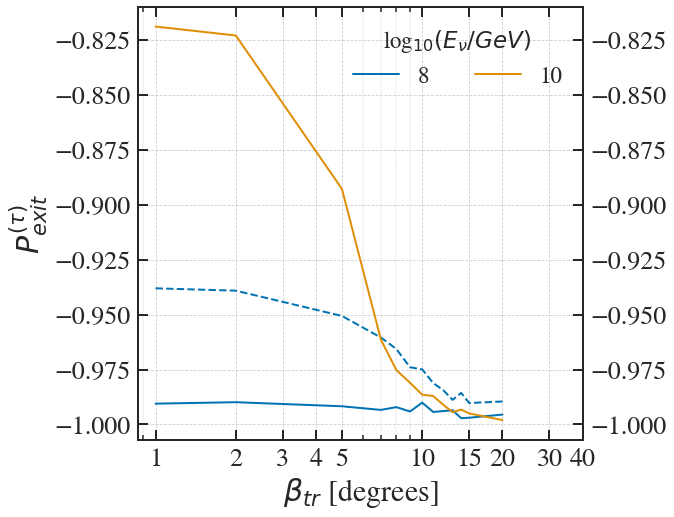

In [15]:
energies = np.arange(8,11,1) # neutrino energies (change according to specific needs)

fig, axs = plt.subplots(1, figsize=(10/1.1, 8/1.1))

energy_grp = [] # so that 7, 7.25, etc. are grouped into the same legend

lines = ["--","-.",":",(0,(3,1,1,1))]
linecycler = cycle(lines)

# colors = ['r','g','b','k','m']
# color_map = cycle(colors)
color_map = cycle(sns.color_palette("colorblind"))

for i,energy in enumerate(energies):

    angles = data.get_polarization(nu_type, ch_lepton, 10**energy, idepth, cross_section_model, pn_model, prop_type, stats)[0] # Earth emergence angles
    polarization = data.get_polarization(nu_type, ch_lepton, 10**energy, idepth, cross_section_model, pn_model, prop_type, stats)[1] # average polarization

    energy_log = float(np.log10(10**energy))

    if int(np.log10(energy)) not in energy_grp:
        color = next(color_map)
        energy_grp.append(int(np.log10(energy)))

        if energy_log%2 == 0 or (energy_log+1)%2 == 0:
            axs.semilogx(angles, polarization, c = color, label = '%.0d' % energy_log)
        else:
            axs.semilogx(angles, polarization, c = color, label = '%.2f' % energy_log)
            
    else:
        axs.semilogx(angles, polarization, ls = next(linecycler), color = color)


axs.legend(loc='best', ncol=2, title = r'log$_{10}(E_{\nu}/GeV)$', frameon=False, framealpha=0.5, fontsize=23)

ticks = (1,2,3,4,5,10,15,20,30,40)
axs.set_xticks(ticks)
axs.set_xticklabels([i for i in ticks])
axs.grid(which='major', axis='both', linestyle='--')
axs.grid(which='minor', linestyle=':', linewidth='0.2', color='black')
axs.xaxis.set_ticks_position('both')
axs.yaxis.set_ticks_position('both')
axs.tick_params(axis='x', which='both', labelbottom = True, labeltop = False)
axs.tick_params(axis='y', which='both', left = True, labelleft = True, labelright= True)
for axis in [axs.xaxis]:
    axis.set_major_formatter(ScalarFormatter())
    
axs.set_xlabel(r"$\beta_{tr}$ [degrees]")
if ch_lepton=='tau':axs.set_ylabel(r'$P^{(\tau)}_{exit}$')
if ch_lepton=='muon':axs.set_ylabel(r'$P^{(\mu)}_{exit}$')
#axs.set_title(r"$P_{exit}$ Vs. Earth Emergence Angles for %ss" % str.capitalize(ch_lepton), fontsize=27)
# axs.set_ylim(1e-6,1e-1)
# axs.set_xlim(1,42)
plt.tight_layout()
#plt.savefig('pexit-rainbow.pdf', bbox_inches='tight', dpi=400)
plt.show()